# How To Run Our Models Step By Step


In [20]:
%load_ext autoreload
%autoreload 2

#Imports Neccessary
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.datasets import IMDB
from torchtext.transforms import ToTensor
from torchtext.vocab import build_vocab_from_iterator
#Pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import time

#MOdel Architectures
from NNDL.transformer.architecture import TransformerModel,TransformerMetaModel
from NNDL.RNN.architecture import RNN,MyNetwork
from NNDL.TestModel.structure import FCNN
import NNDL.Utils.solver as solver
from NNDL.Utils.weight_tracker import ActivationMonitor
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from transformers import AutoTokenizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Pick Your Universal Hyperparamaters:

In [21]:
#For all Models
batch_size = 32
epochs = 3
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#For all text models
input_dim = 100
hidden_dim = 50
output_dim = 10

#For CNN
n_filters=30
filter_size=5
drop_frac=0.5

#For Embedding Layers
embed_dim = 50

#Dataset Portions for the Base Models
train_size = 0.2
test_size = 0.1
#Dataset Portion for the Meta model(Taken out of data not used by base models)
meta_train_size = 0.2
meta_test_size = 0.1

torch.cuda.amp.autocast()
device = "cpu" # Run on CPU for your own work: some parts of the ensemble model do no have GPU support
print(f"==>> torch.cuda.is_available(): {torch.cuda.is_available()}")
print(device)


==>> torch.cuda.is_available(): True
cpu


# Setup Of Dataset/Data Loaders Here




In [22]:
#Custom Dataloader Class that parses the CSV into a format usable by Text
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from transformers import BertTokenizer
from PIL import Image
import requests
from torchvision.io import read_image
import torchvision.transforms as transforms

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Input text
text = "Hello, how are you doing?"

vec = GloVe(name='6B', dim=embed_dim)
class FullDataset(Dataset):
    def __init__(self, data, root_dir):
        self.root_dir = root_dir
        self.data = data
        self.mapping = {'arts, crafts & sewing': 0,'books': 1, 'clothing, shoes & jewelry': 2,'electronics': 3, 'grocery & gourmet food': 4,'health & personal care': 5, 'musical instruments': 6, 'patio, lawn & garden': 7,'sports & outdoors': 8, 'toys & games': 9}
        self.cur_map = 0
        self.print_data=False
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        if  type(self.data.iloc[index, 0]) == float:
            t="N/A"     
            print('N/A Example  In dataset')
        else:
            t=self.data.iloc[index, 0]
        tokens = tokenizer.tokenize(t)
        token_length=input_dim
        tokens=tokens+[""] * (token_length-len(tokens))  if len(tokens)<token_length else tokens[:token_length]
        tokens_emb = [vec.stoi.get(token, 0) for token in tokens]
        img_link = os.path.join(self.data.iloc[index, 1])
        category_text = os.path.join(self.data.iloc[index, 2])
        if category_text in self.mapping:
            category = self.mapping[category_text]
        else:
            print(category_text)
            self.mapping[category_text] = self.cur_map
            print("HOUSTON WE GOT A PROBLEM")
            print(self.mapping)
            category = self.cur_map
            self.cur_map+=1
        try:
            image = Image.open(requests.get(img_link, stream=True).raw) 
        except:
            print(img_link)
        image= image.resize((64,64))
        transform = transforms.Compose([transforms.PILToTensor()])
        torch_image = transform(image)
        if torch_image.shape[0] != 3:
            print(img_link)
            print("WTF")
            print(torch_image.shape)
            x=torch.zeros_like(torch_image)
            torch_image=torch.cat([torch_image,x,x],dim=0)
            print(f"Post correction shape:{torch_image.shape}")
        if self.print_data==True:
            print(f"img_link:{img_link}")
            print(f"Name+Desciption{t}")
        return torch.tensor(tokens_emb),torch_image,category


In [23]:
#For Transformer,CNN,RNN
d = pd.read_csv(r'data/test_remove_filtered.csv') #Place You Path to the CSV file  here

full_dataset = FullDataset(data=d,root_dir='/')

train,test,meta = torch.utils.data.random_split(full_dataset,[train_size,test_size,1-(train_size+test_size)])
train_dataloader =  DataLoader(train, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataloader =  DataLoader(test, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
meta_train,meta_test,trash = torch.utils.data.random_split(meta,[meta_train_size,meta_test_size,1-(meta_train_size+meta_test_size)])
meta_train_dataloader = DataLoader(meta_train, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
meta_test_dataloader = DataLoader(meta_test, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)

# FOR THE BASE MODELS

## Declare The Base Model Architectures

1. Create your model architecture in your folder
2. Pick your loss function and optimizer

In [24]:

model = TransformerModel(input_dim,embed_dim,output_dim).to(device)
#model2 = MyNetwork(embed_dim,n_filters,filter_size,drop_frac,output_dim,embed_dim).to(device)
#model3= RNN(input_dim,hidden_dim,output_dim,embed_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
base_optimizer1 = torch.optim.Adam(model.parameters(),lr=1e-3)
#base_optimizer2 = torch.optim.Adam(model2.parameters(),lr=1e-3)
#base_optimizer3 = torch.optim.Adam(model3.parameters(),lr=1e-3)



## Either Load In an Existing Base Model Using this Format:

Progress: 1/147,accuracy:0.5,test_loss:0.721150
Progress: 2/147,accuracy:1.1,test_loss:0.576040
Progress: 3/147,accuracy:1.7,test_loss:0.516087
Progress: 4/147,accuracy:2.2,test_loss:0.536186
Progress: 5/147,accuracy:2.8,test_loss:0.483229
Progress: 6/147,accuracy:3.4,test_loss:0.483118
Progress: 7/147,accuracy:4.0,test_loss:0.505139
Progress: 8/147,accuracy:4.6,test_loss:0.497467
Progress: 9/147,accuracy:5.1,test_loss:0.542149
Progress: 10/147,accuracy:5.6,test_loss:0.572480
Progress: 11/147,accuracy:6.2,test_loss:0.558473
Progress: 12/147,accuracy:6.8,test_loss:0.544368
Progress: 13/147,accuracy:7.4,test_loss:0.528170
Progress: 14/147,accuracy:8.0,test_loss:0.507391
Progress: 15/147,accuracy:8.5,test_loss:0.509666
Progress: 16/147,accuracy:9.1,test_loss:0.526753
Progress: 17/147,accuracy:9.6,test_loss:0.533302
Progress: 18/147,accuracy:10.2,test_loss:0.539203
Progress: 19/147,accuracy:10.7,test_loss:0.542805
Progress: 20/147,accuracy:11.3,test_loss:0.546294
Progress: 21/147,accuracy:

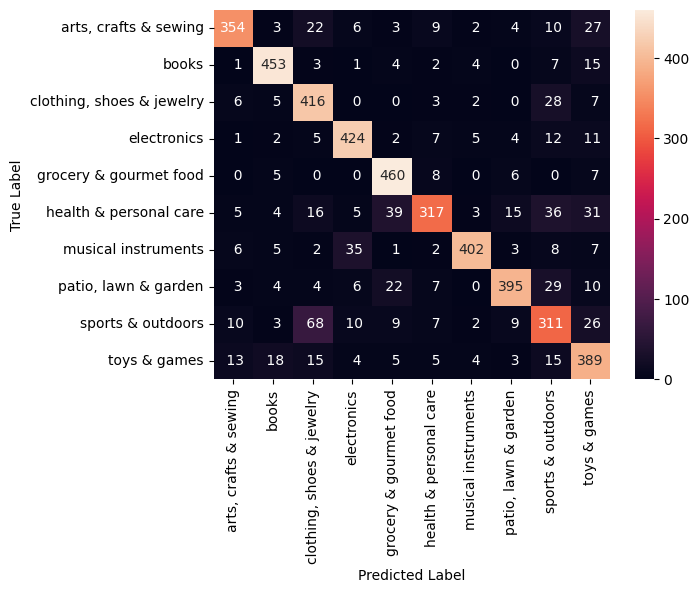

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.534195 



In [34]:
state_dict = torch.load(f"models\TransformerModel/0.7-0.1_epochs-0.pt") # the path should be the path to the saved checkpoints
model.load_state_dict(state_dict)
solver.test(test_dataloader,model,loss_fn)

## OR Train a Model Using this format:

In [26]:
for t in range(epochs):
    #with torch.autograd.detect_anomaly():
        print(f"Epoch {t+1}\n-------------------------------")
        solver.train(train_dataloader, model, loss_fn, base_optimizer1)
        torch.save(model.state_dict(), f"models\{type(model).__name__}\{train_size}-{test_size}_epochs-{t}.pt")
        torch.cuda.empty_cache()
        solver.test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.792532  [   32/ 9432]
http://ecx.images-amazon.com/images/I/31pYPn%2BXhfL._SX300_.jpg


UnboundLocalError: local variable 'image' referenced before assignment

# FOR THE META MODEL:

## Load In all The Neccessary Base ModelS

### Some Tensorflow Specific Integrations for the image model(which is in tensorflow)

In [28]:
import functools
import tensorflow as tf

top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
top2_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'
custom_objects = {'top3_acc':top3_acc, 'top2_acc':top2_acc}
#Use Tensorflow Model
t_model = tf.keras.models.load_model("models\image\gln_model_Qc0Yq7.keras",custom_objects=custom_objects)
t_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Declare and Prepare all your models for one of the ensemble methods

In [30]:

model1 = TransformerModel(input_dim,embed_dim,output_dim).to(device)
model2 = MyNetwork(embed_dim,n_filters,filter_size,drop_frac,output_dim,embed_dim).to(device)
model3= RNN(input_dim,hidden_dim,output_dim,embed_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
state_dict = torch.load(f"models\TransformerModel/0.25-0.05_epochs-0.pt")
model1.load_state_dict(state_dict)
state_dict = torch.load(f"models\MyNetwork/0.25-0.05_epochs-0.pt")
model2.load_state_dict(state_dict)

model_list= [model1,model2]# You need to place every text model into this list
weights = [0.5,0.25,0.25] # You need to place a weightage to be given for every model's output(last index is the image model)


### EITHER Use Naive Averaging of Outputs as the Ensemble Method 

Beginnning inference
Testing Prediction
Progress: 1/147,accuracy:0.6,test_loss:1.027522
Testing Prediction
Progress: 2/147,accuracy:1.1,test_loss:1.078115
Testing Prediction
Progress: 3/147,accuracy:1.6,test_loss:1.073324
Testing Prediction
Progress: 4/147,accuracy:2.2,test_loss:1.032815
Testing Prediction
Progress: 5/147,accuracy:2.8,test_loss:1.032463
Testing Prediction
Progress: 6/147,accuracy:3.3,test_loss:1.021586
Testing Prediction
Progress: 7/147,accuracy:3.9,test_loss:1.031004
Testing Prediction
Progress: 8/147,accuracy:4.3,test_loss:1.052914
Testing Prediction
Progress: 9/147,accuracy:4.8,test_loss:1.056593
Testing Prediction
Progress: 10/147,accuracy:5.4,test_loss:1.053956
Testing Prediction
Progress: 11/147,accuracy:5.9,test_loss:1.060998
Testing Prediction
Progress: 12/147,accuracy:6.5,test_loss:1.044339
Testing Prediction
Progress: 13/147,accuracy:7.0,test_loss:1.056038
Testing Prediction
Progress: 14/147,accuracy:7.6,test_loss:1.050667
Testing Prediction
Progress: 15/147,

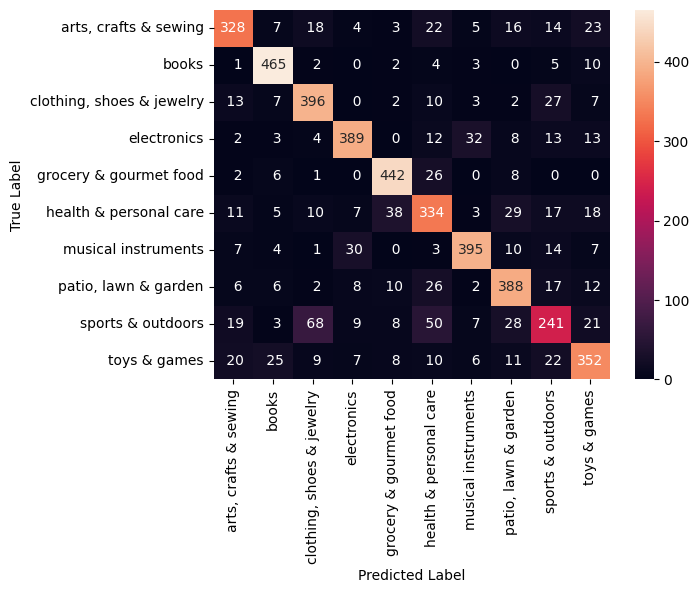

Test Error: 
 Accuracy: 79.1%, Avg loss: 1.056892 



In [31]:
weights = [0.33,0.33,0.33]

solver.test_ensemble(test_dataloader, model_list, loss_fn,t_model,weights)

## OR use weighted Averaging of outputs as the ensemble model

In [32]:
weights = [0.33,0.33,0.33] # Choose custom weights here: idx correspondss to model number, last idx is the image model

solver.test_ensemble(test_dataloader, model_list, loss_fn,t_model,weights)

Beginnning inference
Testing Prediction
Progress: 1/147,accuracy:0.6,test_loss:0.950619
Testing Prediction
Progress: 2/147,accuracy:1.1,test_loss:1.040287
Testing Prediction
Progress: 3/147,accuracy:1.6,test_loss:1.089526
Testing Prediction
Progress: 4/147,accuracy:2.1,test_loss:1.064426
Testing Prediction
Progress: 5/147,accuracy:2.7,test_loss:1.069670
http://ecx.images-amazon.com/images/I/41TFDybTf6L._SY300_.jpg


UnboundLocalError: local variable 'image' referenced before assignment

## OR Train A Meta Model On the Predictions of your base models:

In [33]:
#Declare your Meta Model Architecture

#meta_model = FCNN(output_dim*(len(model_list)+1),hidden_dim*(len(model_list)+1),output_dim).to(device)
meta_model=TransformerMetaModel(len(model_list)+1,output_dim,output_dim)
optimizer = torch.optim.Adam(meta_model.parameters(),lr=1e-3)

# This is the training portion
for t in range(epochs):
    #with torch.autograd.detect_anomaly():
        print(f"Epoch {t+1}\n-------------------------------")
        solver.train_stack(meta_train_dataloader,model_list,loss_fn,optimizer,meta_model,t_model)
        torch.save(meta_model.state_dict(), f"models\{type(meta_model).__name__}\{meta_train_size}-{meta_test_size}_epochs-{t}.pt") # this will save your model weights to a directory with the name of the model architecture name
        torch.cuda.empty_cache()
        solver.test_stack(meta_train_dataloader,model_list,loss_fn,meta_model,t_model)
        


Epoch 1
-------------------------------
Training Meta Model
loss: 2.591773  [   32/ 6602]
loss: 2.591773  [   32/ 6602]
loss: 2.789546  [   64/ 6602]
loss: 2.538496  [   96/ 6602]
loss: 2.510524  [  128/ 6602]
loss: 2.350821  [  160/ 6602]
loss: 2.302735  [  192/ 6602]
loss: 2.495427  [  224/ 6602]
loss: 2.342085  [  256/ 6602]
loss: 2.245266  [  288/ 6602]
loss: 2.095569  [  320/ 6602]
loss: 2.392676  [  352/ 6602]
loss: 2.211416  [  384/ 6602]
loss: 2.027610  [  416/ 6602]
loss: 2.258869  [  448/ 6602]
loss: 2.292414  [  480/ 6602]
loss: 2.146991  [  512/ 6602]
loss: 2.169219  [  544/ 6602]
loss: 2.065369  [  576/ 6602]
loss: 2.037255  [  608/ 6602]
loss: 1.923294  [  640/ 6602]
loss: 2.024649  [  672/ 6602]
loss: 1.968048  [  704/ 6602]
loss: 1.983702  [  736/ 6602]
loss: 2.086825  [  768/ 6602]
loss: 2.028045  [  800/ 6602]
loss: 1.886442  [  832/ 6602]
loss: 1.896928  [  864/ 6602]
loss: 1.985428  [  896/ 6602]
loss: 2.151915  [  928/ 6602]
loss: 1.987231  [  960/ 6602]
loss: 1.88

UnboundLocalError: local variable 'image' referenced before assignment

In [ ]:
#Sanity Check With Single Examples(currently not working)
with torch.no_grad():
    class_names=['arts, crafts & sewing','books', 'clothing, shoes & jewelry','electronics', 'grocery & gourmet food','health & personal care', 'musical instruments', 'patio, lawn & garden','sports & outdoors','toys & games']
    X_text,X_img, actual_label = next(iter(meta_test_dataloader))
    actual_label = actual_label[0]
    #PRedicting USing Models
    X_img=torch.transpose(X_img,1,3)
    X_img = X_img.numpy()
    X_img = tf.convert_to_tensor(X_img)
    X_img=tf.cast(X_img,tf.float32)
    X_img=tf.keras.applications.inception_v3.preprocess_input(X_img)
    pred_by_model = []
    for model in model_list:
        out = model(X_text)
        pred_by_model.append(out)
    t_out=t_model.predict(X_img)
    t_out=torch.tensor(t_out)
    pred_by_model.append(t_out)
    for it,weight in enumerate(weights):
        pred_by_model[it]*=weight
    stacked_tensor = torch.stack(pred_by_model)
    pred = torch.sum(stacked_tensor,axis=0)
    pred=np.argmax(np.array(pred), axis=1)
    print(f"The Meta Model Predicted:{class_names[pred[0]]},while the actual class was {class_names[actual_label]}")

NameError: name 'torch' is not defined